In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

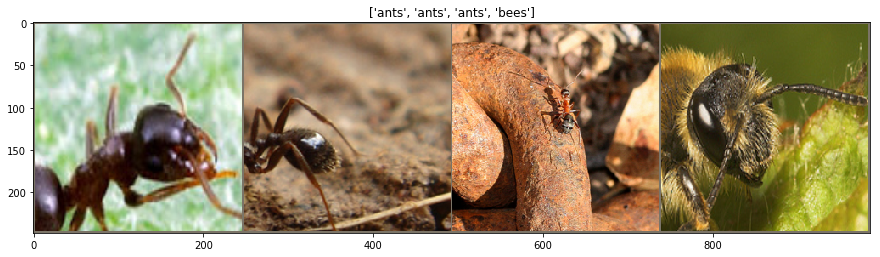

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-0.4739, -0.3712, -0.3712,  ..., -0.8164, -0.8335, -0.8164],
         [-0.5424, -0.3883, -0.3198,  ..., -0.8335, -0.7822, -0.7993],
         [-0.4911, -0.3369, -0.2684,  ..., -0.8335, -0.8164, -0.7993],
         ...,
         [-0.2856, -0.3027, -0.3027,  ..., -0.1999, -0.2171, -0.2342],
         [-0.2856, -0.3027, -0.3027,  ..., -0.1486, -0.1143, -0.1999],
         [-0.2684, -0.3198, -0.3369,  ..., -0.0972, -0.0629, -0.1314]],

        [[-0.3375, -0.2500, -0.2500,  ..., -0.2850, -0.2675, -0.2850],
         [-0.3550, -0.2500, -0.2675,  ..., -0.3375, -0.3200, -0.3200],
         [-0.3725, -0.2325, -0.2325,  ..., -0.3375, -0.3375, -0.3550],
         ...,
         [-0.1099, -0.0749, -0.0574,  ...,  0.5028,  0.5028,  0.4503],
         [-0.1099, -0.0574, -0.0049,  ...,  0.4853,  0.5203,  0.5203],
         [-0.0399, -0.0224, -0.0049,  ...,  0.5203,  0.5378,  0.5553]],

        [[-1.0550, -1.0376, -1.1247,  ..., -1.7347, -1.7347, -1.7347],
         [-1.0724, -1.0376, -1.1596,  ..., -1

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [9]:
# Ваш код здесь
model_extractor = models.inception_v3(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\Nordlands/.torch\models\inception_v3_google-1a9a5a14.pth
100%|███████████████████████| 108857766/108857766 [00:17<00:00, 6332115.40it/s]


In [10]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1568 Acc: 0.6230
val Loss: 0.0998 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.1335 Acc: 0.7459
val Loss: 0.0773 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.1062 Acc: 0.8238
val Loss: 0.0867 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.1190 Acc: 0.7377
val Loss: 0.0628 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.1018 Acc: 0.8279
val Loss: 0.0609 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.1166 Acc: 0.7869
val Loss: 0.0608 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.1185 Acc: 0.7828
val Loss: 0.0827 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.0900 Acc: 0.8320
val Loss: 0.0634 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.0868 Acc: 0.8566
val Loss: 0.0548 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0756 Acc: 0.8525
val Loss: 0.0604 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0944 Acc: 0.8156
val Loss: 0.0596 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0973 Acc: 0.8156
val Loss: 0.0547 Acc: 0.9281

Ep